<a href="https://colab.research.google.com/github/Karenjbc7/T-picos/blob/main/Cambio_nodos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primero se carga la base de datos en Google Colab. Inicialmente no se especifica qué elemento y tipo de elemento es.

In [1]:
from google.colab import files # Para cargar archivos en google colab
uploaded = files.upload()

Saving serie_completa (1).csv to serie_completa (1).csv


A continuación, se transforma el archivo CSV mediante la función read_csv de pandas. En esta línea de código se tiene en cuenta el separador y la codificación de texto en latino.

In [2]:
import pandas as pd
import io
serie_covid1 = io.BytesIO(uploaded['serie_completa (1).csv'])
serie_covid = pd.read_csv(serie_covid1, sep = ",", encoding="latin-1")
serie_covid.head(4)

,Fecha,Frecuencia
0,2020-02-27,1
1,2020-02-28,2
2,2020-02-29,2
3,2020-03-01,4


In [3]:
serie_covid.tail(4)

,Fecha,Frecuencia
1415,2024-01-12,53
1416,2024-01-13,21
1417,2024-01-14,9
1418,2024-01-15,1


Se realiza una visualización de los datos. Se observa que el comportamiento inicial de la serie de tiempo presenta picos muy altos en comparación con los valles. A partir de enero de 2023 ya no se observan picos y valles significativos.

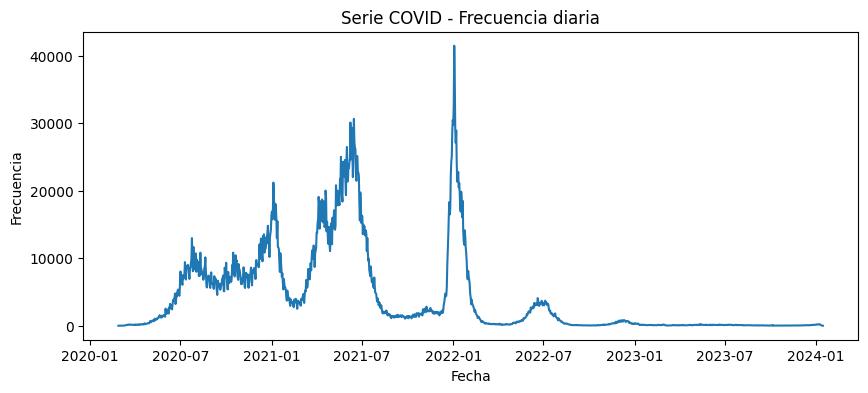

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

serie_covid['Fecha'] = pd.to_datetime(serie_covid['Fecha'])
serie_covid = serie_covid.sort_values('Fecha').reset_index(drop=True) # Ordenar por fecha por si acaso
plt.figure(figsize=(10,4))
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'])
plt.title('Serie COVID - Frecuencia diaria')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.show()

Se hace un reescalamiento de los datos. Esto porque al ser los datos en orden de décimas de miles, el método de estimación de parámetros no llegue a una convergencia. Más aún, cuando en una red LSTM se tienen muchos más parámetros involucrados que en una red de perceptrón multicapa.

In [5]:
scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie_covid['Frecuencia'].values.reshape(-1, 1)) # Acá se hace un escalamiento de los datos
serie_scaled

array([[0.00000000e+00],
       [2.41062604e-05],
       [2.41062604e-05],
       ...,
       [4.82125208e-04],
       [1.92850083e-04],
       [0.00000000e+00]])

In [6]:
def crear_secuencias(data, pasos): # Para crear ventanas temporales
    X, y = [], []
    for i in range(len(data) - pasos):
        X.append(data[i:i + pasos])
        y.append(data[i + pasos])
    return np.array(X), np.array(y)
# data = [10, 20, 30, 40, 50, 60, 70], pasos = 3 (ventana de 3 días). Los bucles generados sera así [10, 20, 30]

pasos = 30 # Tamaño de ventana temporal (por ejemplo 30 días)
X, y = crear_secuencias(serie_scaled, pasos)
print(f"X.shape = {X.shape}, y.shape = {y.shape}")
# X.shape = (1389, 30, 1) Hay 1389 datos, cada uno con de 30 filas y 1 columna

X.shape = (1389, 30, 1), y.shape = (1389, 1)


Se selecciona el 80% de los datos como datos de entrenamiento, correspondiente a los 1111 primeros días del período de tiempo con datos. El resto de datos (20%), es decir, del día 1112 al último día corresponden a los datos de validación.

In [7]:
train_size = int(len(X) * 0.8) # División del conjunto de datos
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

print("X_train:", X_train.shape, ", Tamaño entrenamiento: {len(X_train)}")
print("y_train:", y_train.shape, ", Tamaño validación: {len(X_val)}")

X_train: (1111, 30, 1) , Tamaño entrenamiento: {len(X_train)}
y_train: (1111, 1) , Tamaño validación: {len(X_val)}


Se representa en la serie el conjunto de datos de entrenamiento y de validación.

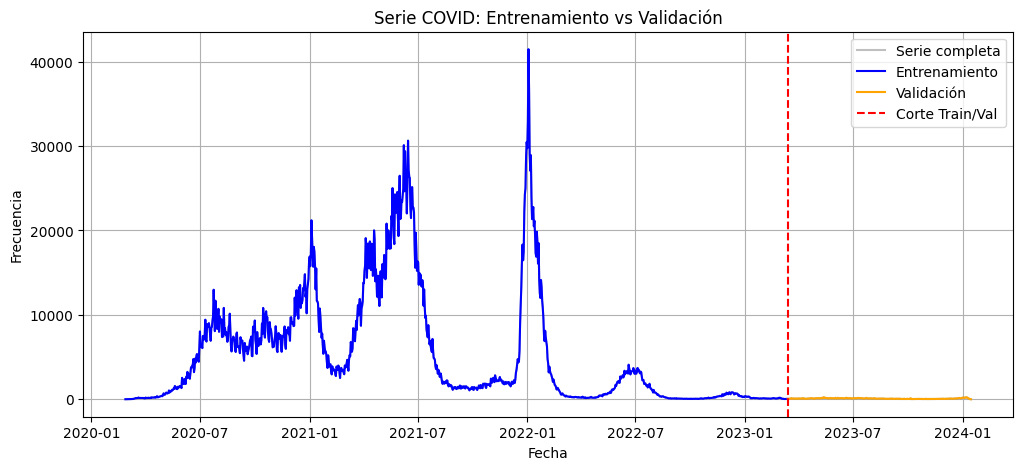

In [8]:
fecha_entrenamiento = serie_covid['Fecha'][:train_size]
fecha_validacion = serie_covid['Fecha'][train_size:]

plt.figure(figsize=(12,5))
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], color='gray', alpha=0.5, label='Serie completa')

plt.plot(fecha_entrenamiento, serie_covid['Frecuencia'][:train_size], color='blue', label='Entrenamiento')
plt.plot(fecha_validacion, serie_covid['Frecuencia'][train_size:], color='orange', label='Validación')

# Líneas divisorias
plt.axvline(x=serie_covid['Fecha'].iloc[train_size], color='red', linestyle='--', label='Corte Train/Val')

plt.title('Serie COVID: Entrenamiento vs Validación')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.show()


Se fija el número de neuronas que tendrá el modelo LSTM a implementar.

In [9]:
dim_entrada = (X_train.shape[1],1) # Cada entrada es una secuencia de 30 pasos temporales, con una sola característica por paso temporal.
dim_salida = 1 # El modelo debe predecir un solo valor (por ejemplo, el siguiente valor en la secuencia).
na = 200 # La red tendrá una capa oculta con na neuronas, lo que afecta su capacidad de aprendizaje.

SE aumentan los nodos, primers LSTM 64, segunda 72.

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam

modelo = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(72),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

modelo.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 72)             │        39,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,089 (238.63 KB)

 Trainable params: 61,089 (238.63 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist = modelo.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 9.3895e-04 - val_loss: 8.3306e-06
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 8.0398e-04 - val_loss: 7.2944e-06
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 8.7530e-04 - val_loss: 2.0604e-05
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 8.2879e-04 - val_loss: 6.4138e-06
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.0576e-04 - val_loss: 1.8303e-05
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.6124e-04 - val_loss: 1.8080e-06
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 9.5767e-04 - val_loss: 7.9061e-07
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.6988e-04 - val_loss: 2.7961e-05
Epoch 9/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.1669e-04 - val_loss: 1.1765e-06
Epoch 10/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 9.4451e-04 - val_loss: 2.0018e-05
Epoch 11/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss

Se muestra la mejor época para la estimación bajo la cual se tiene mejor valor de la función de pérdida para los datos de entrenamiento y de validación

In [58]:
val_loss = np.array(hist.history['val_loss'])
train_loss = np.array(hist.history['loss'])
best_epoch = np.argmin(val_loss)
print(f"Mejor época (mínimo val_loss): {best_epoch+1} (0-based index {best_epoch})")
print(f"val_loss_min = {val_loss[best_epoch]:.6e}, train_loss en esa época = {train_loss[best_epoch]:.6e}")

Mejor época (mínimo val_loss): 15 (0-based index 14)
val_loss_min = 4.045054e-07, train_loss en esa época = 9.120302e-04


Se estiman los parámetros para los datos de entrenamiento

In [59]:
modelo.fit(X_train,y_train, epochs= best_epoch, batch_size=32) # Entrenamiento

Epoch 1/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 8.8941e-04
Epoch 2/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.6087e-04
Epoch 3/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.5465e-04
Epoch 4/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.6250e-04
Epoch 5/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 8.1127e-04
Epoch 6/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 8.6477e-04
Epoch 7/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.9622e-04
Epoch 8/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 8.3434e-04
Epoch 9/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0010
Epoch 10/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.6483e-04
Epoch 11/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.1739e-04
Epoch 12/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.2411e-04
Epoch 13/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.5006e-04
Epoch 14/14
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.5947e-04


En el grafico se observa que la perdida entrenamiento es mayor que val_loss, esto muestra un patrón anormal. El modelo tiene más dificultad con el conjunto de entrenamiento.

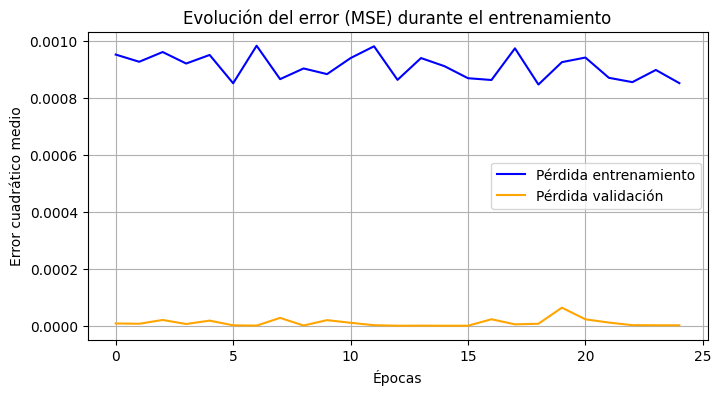

In [60]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], label='Pérdida entrenamiento', color='blue')
plt.plot(hist.history['val_loss'], label='Pérdida validación', color='orange')
plt.title('Evolución del error (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.grid(True)
plt.show()

.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


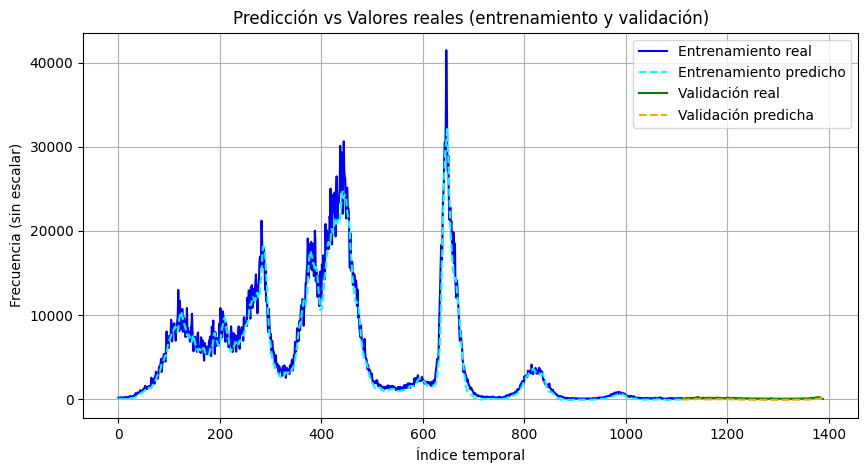

    Real   Predicho
0   62.0 -61.408157
1   50.0 -64.476242
2   78.0 -70.028496
3   65.0 -73.824295
4   81.0 -77.453964
5   84.0 -79.052101
6   78.0 -78.649529
7   96.0 -77.765892
8  122.0 -74.407280
9  104.0 -67.025780


In [46]:
pred_train = modelo.predict(X_train)
pred_val = modelo.predict(X_val)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1)) # Desescala tanto el entrenamiento como la validación
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))
pred_train_inv = scaler.inverse_transform(pred_train)
pred_val_inv = scaler.inverse_transform(pred_val)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(y_train_inv)), y_train_inv, label='Entrenamiento real', color='blue')
plt.plot(np.arange(len(y_train_inv)), pred_train_inv, label='Entrenamiento predicho', color='cyan', linestyle='--')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_val_inv)), y_val_inv, label='Validación real', color='green')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_val_inv)), pred_val_inv, label='Validación predicha', color='orange', linestyle='--')
plt.title('Predicción vs Valores reales (entrenamiento y validación)')
plt.xlabel('Índice temporal')
plt.ylabel('Frecuencia (sin escalar)')
plt.legend()
plt.grid(True)
plt.show()

# --- Comparación en tabla ---
comparacion = pd.DataFrame({
    'Real': y_val_inv.flatten(),
    'Predicho': pred_val_inv.flatten()
})
print(comparacion.head(10))


Al aumentar los nodos, el coeficiente de determinación disminuyó, lo cual muestra que hay overfitting, el modelo está memorizando el entrenamiento y generaliza mal, las predicciones son lejanas a los valores reales.

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("\nEvaluación en validación:")
print(" MAE:", mean_absolute_error(y_val_inv, pred_val_inv))
print(" RMSE:", np.sqrt(mean_squared_error(y_val_inv, pred_val_inv)))
print(" R2:", r2_score(y_val_inv, pred_val_inv))


Evaluación en validación:
 MAE: 147.5169490194149
 RMSE: 149.98701102887784
 R2: -9.715894780022726


In [32]:
ventana = 30  # o el número de pasos que usaste al crear las secuencias
ultimos_datos_scaled = serie_scaled[-ventana:]  # últimos 30 valores de la serie escalada
ultimos_datos_scaled = ultimos_datos_scaled.reshape(1, ventana, 1)  # formato 3D (batch, timesteps, features)
print(ultimos_datos_scaled.shape)

(1, 30, 1)


Se realizan las predicciones del modelo en períodos de tiempo no observados.

In [33]:
n_pred = 15  # número de días a predecir
ventana = 30  # mismo tamaño de ventana
X_pred = ultimos_datos_scaled.copy()
predicciones_futuras = []

for _ in range(n_pred):
    pred = modelo.predict(X_pred, verbose=0)  # pred.shape = (1, 1)
    predicciones_futuras.append(pred[0, 0])
    nuevo_valor = np.reshape(pred, (1, 1, 1)) # Convertir la predicción en la misma forma (1, 1, 1)
    X_pred = np.concatenate([X_pred[:, 1:, :], nuevo_valor], axis=1) # Concatenar correctamente (manteniendo las 3 dimensiones)

# Convertir a array y desescalar
predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)

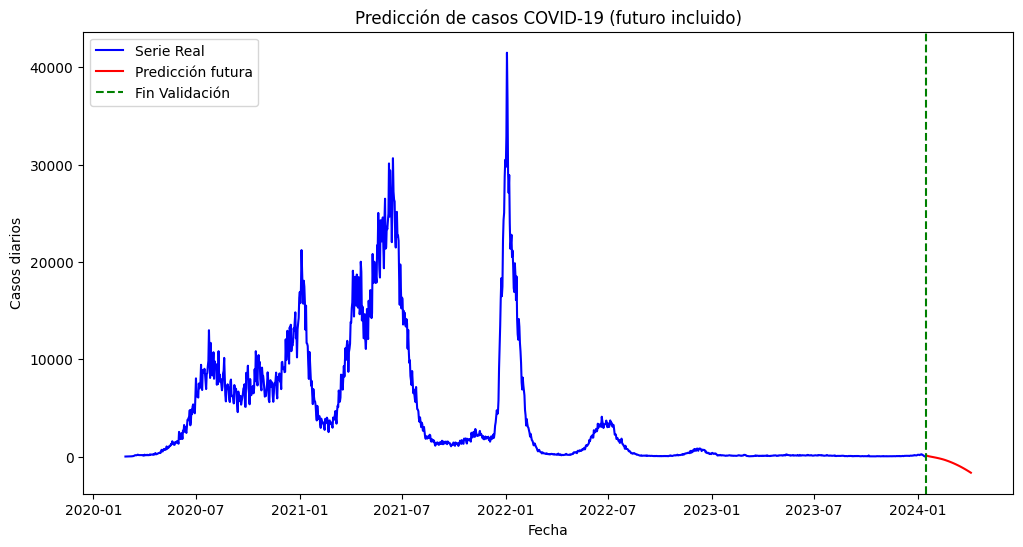

In [34]:
n_futuro = 80

ult_fecha = serie_covid['Fecha'].max() # 2. Crear fechas futuras
fechas_futuras = pd.date_range(start=ult_fecha + pd.Timedelta(days=1), periods=n_futuro, freq='D')

X_pred = X_val[-1].reshape(1, X_val.shape[1], X_val.shape[2]) # 3. Predicción futura
predicciones_futuras = []

for _ in range(n_futuro):
    pred = modelo.predict(X_pred, verbose=0)
    predicciones_futuras.append(pred[0, 0])
    # Redimensionar pred a (1,1,1) para concatenar correctamente
    pred_reshaped = pred.reshape(1, 1, 1)
    X_pred = np.concatenate((X_pred[:, 1:, :], pred_reshaped), axis=1)

predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1) # 4. Inversa de escalado
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)

plt.figure(figsize=(12, 6)) # 5. Gráfico
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], label='Serie Real', color='blue')
plt.plot(fechas_futuras, predicciones_futuras_inv, label='Predicción futura', color='red', linestyle='-')

plt.axvline(x=ult_fecha, color='green', linestyle='--', label='Fin Validación')
plt.title('Predicción de casos COVID-19 (futuro incluido)')
plt.xlabel('Fecha')
plt.ylabel('Casos diarios')
plt.legend()
plt.show()

Para el modelo GRU se tomaran 192 nodos en la primera y 96 en la segunda.

In [61]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt

modelo1 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(192, return_sequences=True),
    Dropout(0.2),
    GRU(96),
    Dense(1)
])

modelo1.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

La curva de pérdida tiene un descenso inicial rápido, muchas oscilaciones y picos notables en algunas épocas, no observa convergencia.

Epoch 1/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0156 - val_loss: 4.8730e-04
Epoch 2/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.0015 - val_loss: 1.8989e-04
Epoch 3/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.0012 - val_loss: 2.9925e-06
Epoch 4/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0013 - val_loss: 6.8354e-06
Epoch 5/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0013 - val_loss: 8.7762e-06
Epoch 6/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.0011 - val_loss: 1.2707e-05
Epoch 7/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - loss: 0.0012 - val_loss: 8.4309e-05
Epoch 8/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - loss: 0.0010 - val_loss: 6.6985e-06
Epoch 9/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - loss: 0.0010 - val_loss: 3.0767e-05
Epoch 10/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 8.8332e-04 - val_loss: 7.8516e-05
Epoch 11/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 9.5169e-04 - val_loss: 

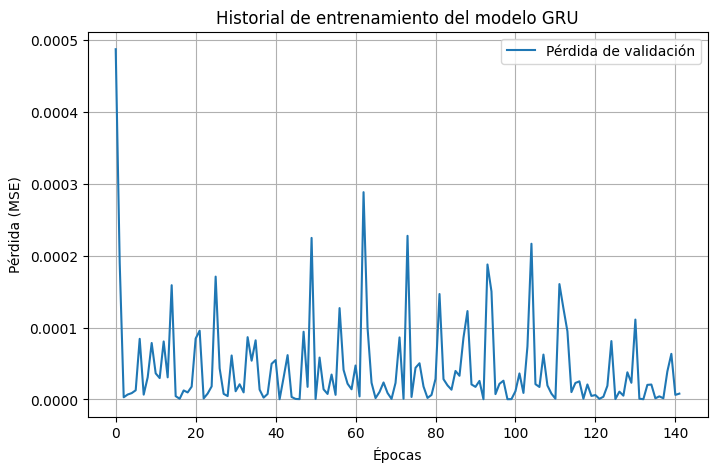

In [62]:
early_stop1 = EarlyStopping(
    monitor='val_loss',       # Métrica de validación a vigilar
    patience=100,              # Detener si no mejora en 10 épocas
    restore_best_weights=True # Restaurar los mejores pesos
)

# ====== Entrenamiento ======
hist1 = modelo1.fit(
    X_train, y_train,
    epochs=400,
    batch_size=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop1],
    verbose=1
)

# ====== Gráfico del historial ======
plt.figure(figsize=(8,5))
# plt.plot(hist1.history['loss'], label='Pérdida de entrenamiento')
plt.plot(hist1.history['val_loss'], label='Pérdida de validación')
plt.title('Historial de entrenamiento del modelo GRU')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
pred_train1 = modelo1.predict(X_train)
pred_val1 = modelo1.predict(X_val)

pred_train_inv1 = scaler.inverse_transform(pred_train1)
pred_val_inv1 = scaler.inverse_transform(pred_val1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


EL coeficiente de determinación es de 0.76, se considera un ajuste bueno.

In [64]:
print("\nEvaluación en validación:")
print(" MAE:", mean_absolute_error(y_val_inv, pred_val_inv1))
print(" RMSE:", np.sqrt(mean_squared_error(y_val_inv, pred_val_inv1)))
print(" R2:", r2_score(y_val_inv, pred_val_inv1))


Evaluación en validación:
 MAE: 15.726969406759139
 RMSE: 22.055747607238644
 R2: 0.768279366989263


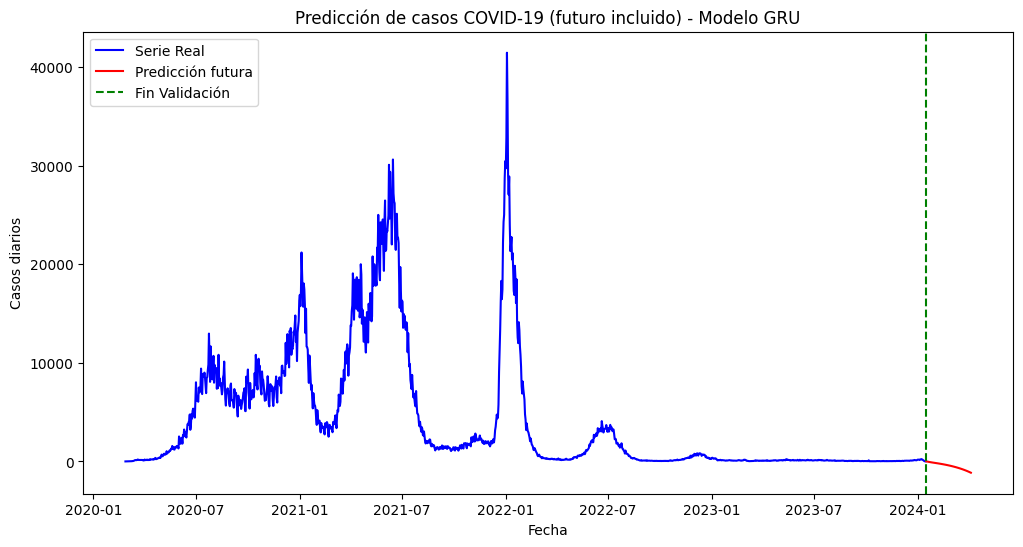

In [65]:
fechas_futuras = pd.date_range(start=ult_fecha + pd.Timedelta(days=1), periods=n_futuro, freq='D')

X_pred = X_val[-1].reshape(1, X_val.shape[1], X_val.shape[2])
predicciones_futuras = []

for _ in range(n_futuro):
    pred = modelo1.predict(X_pred, verbose=0)
    predicciones_futuras.append(pred[0, 0])
    pred_reshaped = pred.reshape(1, 1, 1)
    X_pred = np.concatenate((X_pred[:, 1:, :], pred_reshaped), axis=1)

predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)

# 7. Gráfico general
plt.figure(figsize=(12, 6))
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], label='Serie Real', color='blue')
plt.plot(fechas_futuras, predicciones_futuras_inv, label='Predicción futura', color='red', linestyle='-')
plt.axvline(x=ult_fecha, color='green', linestyle='--', label='Fin Validación')
plt.title('Predicción de casos COVID-19 (futuro incluido) - Modelo GRU')
plt.xlabel('Fecha')
plt.ylabel('Casos diarios')
plt.legend()
plt.show()

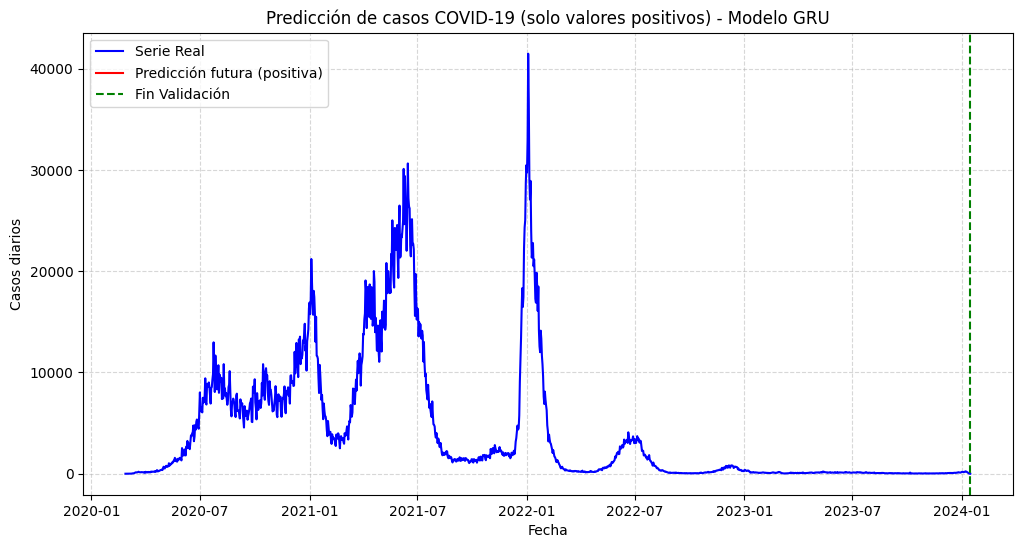

In [66]:
predicciones_futuras_pos = np.ravel(np.array(predicciones_futuras_inv))
fechas_futuras_pos = np.array(fechas_futuras)

# Crear máscara para valores positivos
mask_pos = predicciones_futuras_pos > 0

# Aplicar la máscara
predicciones_futuras_pos = predicciones_futuras_pos[mask_pos]
fechas_futuras_pos = fechas_futuras_pos[mask_pos]

# --- 7. Gráfico general ---
plt.figure(figsize=(12, 6))

# Serie real
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], label='Serie Real', color='blue')

# Predicción futura (solo positivas)
plt.plot(fechas_futuras_pos, predicciones_futuras_pos, label='Predicción futura (positiva)', color='red', linestyle='-')

# Línea vertical del fin de validación
plt.axvline(x=ult_fecha, color='green', linestyle='--', label='Fin Validación')

plt.title('Predicción de casos COVID-19 (solo valores positivos) - Modelo GRU')
plt.xlabel('Fecha')
plt.ylabel('Casos diarios')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

**Conclusiones**

El modelo LSTM muestra un patrón anormal, no overfitting. Además, es recomendable aumentar la complejidad.
El modelo GRU tiene un coeficiente de determinación bueno, aunque se observan oscilaciones en la curva de pérdida. No hay que aumentar la complejidad.
Por lo tanto, el modelo más adecuado es GRU, apesar de que las predicciones futuras son negativas.